In [32]:
import pandas as pd
from pandas.api.types import is_string_dtype
import os
import matplotlib.pyplot as plt



def load_dataset():
    x_train = pd.read_csv(os.path.join("house_data", "train.csv"))

    y_train = x_train["SalePrice"]
    x_train = x_train.drop("SalePrice", axis=1)
    
    return x_train, y_train

x_train, y_train, x_val, y_val = load_dataset()

print(x_train["KitchenQual"].unique())
print(x_train["GarageType"].unique())
print(x_train["HouseStyle"].unique())


['TA' 'Gd' 'Ex' 'Fa']
['Attchd' 'Detchd' nan 'BuiltIn' 'CarPort' 'Basment' '2Types']
['SLvl' '2Story' '1Story' '1.5Fin' 'SFoyer' '1.5Unf' '2.5Fin' '2.5Unf']


## Continuous Features in House Price Dataset

Continuous features are features that can assume any real value within some range. For example, in our dataset three examples of continuous features in our dataset are the area of a house's lot (LotArea), the area of its garage, and the area of its living room. Because we can measure these features to essentially any precision that we want and that they exist on a continuous spectrum, these are continuous features. The figure below shows a histogram plot indicating the distribution of garage areas for the houses in our dataset. From this, we can see that the distribution is somewhat similar to a normal distribution with the majority of homes in our dataset having a garage area of roughly 450 square meters.

(array([ 67., 157., 266., 444., 212., 100.,  54.,   9.,   3.,   2.]),
 array([   0. ,  141.8,  283.6,  425.4,  567.2,  709. ,  850.8,  992.6,
        1134.4, 1276.2, 1418. ]),
 <BarContainer object of 10 artists>)

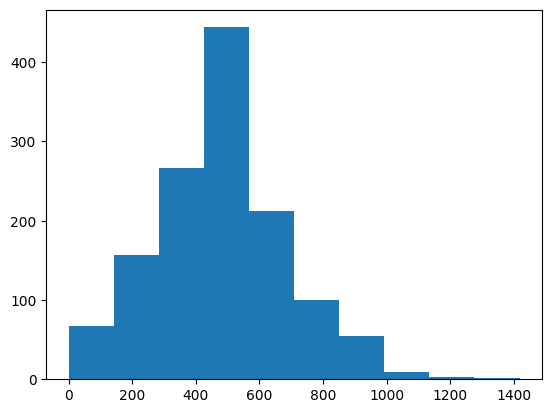

In [30]:
plt.hist(x_train["GarageArea"])

## Discrete Features in the House Price Dataset

Discrete features are features that can only assume a finite set of values that may or may not be numerical. For example, in our dataset, three examples of discrete features are the subjective quality of a person's garage (GarageQual), the type of the garage (is it attached, detached, built in etc.) (GrageType), and the type of the house (HouseStyle) which tells us things like if it's a one-story or two story and if it's furnished or not.  Below is a bar graph showing the distribution of the types of houses in our dataset. From this, we can see that the most common type of homes in our dataset are one story houses followed closely by two story homes. 

<Axes: xlabel='HouseStyle'>

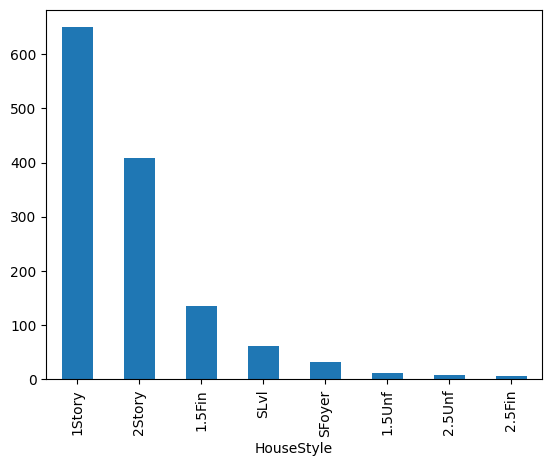

In [33]:
x_train["HouseStyle"].value_counts().plot(kind="bar")

# Preprocessing Dataset

To preprocess the dataset, we performed three main preprocessing operations:

#### One Hot Encoding Categorical Features
1. We first performed preprocessing for the categorical features in our dataset that we believed would be useful. We chose to use the HouseStyle because we believed that things like the number of stories in a house and whether or not it is furnished is very important for determining its house. Since the HouseStyle isn't numerical, we decided to use one hot encoding to convert it into a format that can be used by our model. Now in some cases, one hot encoding isn't the best way to handle categorical features such as when the feature values exist on a scale such as garage quality. In that case a technique like ordinal encoding might be better because then we could preserve the inherent ordering in the feature values which would make it easier for the model to discover and use the relationship. In our case however, there is no readily available ordering that we could use for HouseStyle because while we could go by which type of house has the most features (as in most stories and being furnished), it's hard to tell whether a two story house has more features than a 1.5 furnished story house. Because of this, we decided to instead use one hot encoding to represent this feature.

#### Replacing Nan Values with Column Averages
2. After this, for our continuous features, we replaced any nan values with the average value in the column. If instead, we had removed rows with nan values, we might potentially end up with too little data to train our model. One thing to note however, is that for evaluation on the test set, we replaced nan values with the column wise mean of the corresponding column in our train set and not the test set. This is because in our case, during inference we don't have access to any information outside of our training set and so using the rows in our test set to replace nan values in other rows would be a form of data leakage. This would ultimately result in our model appearing to be more accurate than it actually would be when deployed in the real world.

#### Feature Selection on Continuous Features
3. Finally, because we have a large number of features in our dataset, it was critical that we performed some type of feature selection before training our model. This is because if we didn't do this, our model could end having too many parameters or degrees of freedom and overfit on the training set. And just as using too many degrees in polynomial regression can cause poor generalization, the model would likely not generalize well and would perform poorly on the test set. In order to perform feature selection, for each of our continuous features, we measured the correlation between the continuous feature and the target output, the sale price, and took the ten features with the highest correlation (in magnitude) with the target output. Because of their high correlation, there's a good chance that they are strong indicators of the housing price and would therefore be useful for our model. For the categorical features, we initially included them in this feature selection process after one-hot encoding them but we found that none of them were being selected. As a result, we decided to manually pick the categorical features that we believed would most benefit our model.



In [95]:
def load_dataset():
    x_train = pd.read_csv(os.path.join("house_data", "train.csv"))
    x_test = pd.read_csv(os.path.join("house_data", "test.csv"))

    y_train = x_train["SalePrice"]
    x_train, mean, std = prepare_dataset(x_train)
    x_test = prepare_dataset(x_test, x_train=x_train, mean=mean, std=std)

    x_train = x_train.drop("SalePrice", axis=1)
    x_test = x_test.drop("SalePrice", axis=1)

    return x_train, y_train, x_test


def prepare_dataset(X, x_train=None, mean=0, std=1):

    categorical_features_keep = ["HouseStyle"]

    one_hot_cols = {}
    for col in categorical_features_keep:
        if is_string_dtype(X[col].dtype):
            one_hot = pd.get_dummies(X[col], prefix=col)
            one_hot_cols[col] = one_hot
    
    
    for col in X.columns:
        if is_string_dtype(X[col].dtype):
            X = X.drop(col, axis = 1)
        else:
            X[col] = X[col].fillna(X[col].mean())

    if x_train is not None:
        X = (X - mean)/std
        feature_names = sorted(x_train.columns, key = lambda col: abs(x_train[col].corr(x_train["SalePrice"])), reverse=True)[:11]

    else:
        mean = X.mean()
        std = X.std()
        X = (X - mean)/std
        feature_names = sorted(X.columns, key = lambda col: abs(X[col].corr(X["SalePrice"])), reverse=True)[:11]

    X = X[feature_names]

    for feature in categorical_features_keep:
        X = X.join(one_hot_cols[feature])
    if x_train is not None:
        for col in x_train.columns:
            if col not in X:
                X[col] = [0 for i in range(len(X))]
    if x_train is not None:
        return X
    return X, mean, std

x_train, y_train, x_test = load_dataset()


# One Hot Encoding Exploration: HouseStyle

Below we have constructed histogram plots showing the distribution of each "new feature" created in the one hot encoding of the HouseStyle feature. As can be seen, save for the encoding for the one story and two story classes, the one hot encoding representation is very sparse as the other classes aren't very well represented in our dataset. 

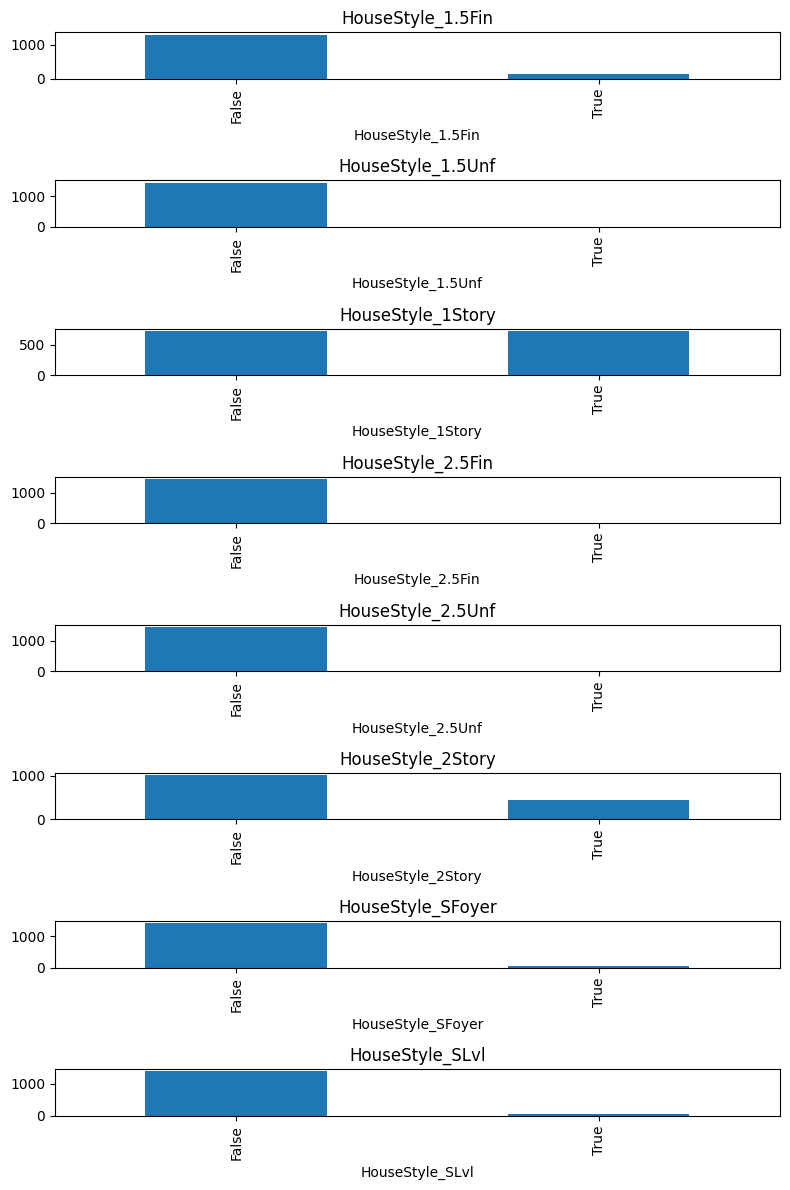

In [50]:

house_style_cols = []

for col in x_train.columns:
    if "HouseStyle" in col:
        house_style_cols.append(col)

fig, axes = plt.subplots(nrows=len(house_style_cols), ncols=1, figsize=(8, 12))

for i, col in enumerate(house_style_cols):
    x_train[col].value_counts().plot(kind="bar", ax=axes[i], title=col)
    
plt.tight_layout()
plt.show()

In [97]:
import numpy as np
from sklearn.metrics import r2_score


def train_model(x_train, y_train):
    x_train_numpy = x_train.to_numpy(dtype=float)
    y_train_numpy = y_train.to_numpy(dtype=float)
    theta_best = np.linalg.inv(x_train_numpy.T.dot(x_train_numpy)).dot(x_train_numpy.T).dot(y_train_numpy)

    return theta_best

def predict(features, theta_best):
    features = features.to_numpy(dtype=float)
    predictions = np.matmul(features, theta_best)
    return predictions

def evaluate(features, target_outputs, theta_best):

    predictions = predict(features, theta_best)
    target_outputs = target_outputs.to_numpy(dtype=float)

    r2 = r2_score(predictions, target_outputs)
    rmse = np.sqrt(np.dot(predictions - target_outputs, predictions - target_outputs)/len(predictions))
    return rmse, r2


theta_best = train_model(x_train, y_train)

rmse, r2 = evaluate(x_train, y_train, theta_best)

predictions=  predict(x_test, theta_best)


test_predictions = pd.DataFrame()
test_predictions["Id"] = [1461 + i for i in range(len(predictions))]
test_predictions["SalePrice"] = predictions

test_predictions.to_csv(os.path.join("house_data", "submission.csv"), index=False)
print(rmse, r2)


37220.437585324675 0.7185042464384948
